In [1]:
import numpy as np
from Bio.PDB.MMCIFParser import MMCIFParser
from Bio.PDB import *
import pandas as pd
import os
import shutil
import matplotlib.pyplot as plt
from pathlib import Path
import glob
import json

# ============================================================================
# CONFIGURATION
# ============================================================================
RESULTS_DIRECTORY = "results/active_template/"  # Base directory containing molecule folders
DIRECTORY_PREFIX = "boltz_results_*"            # Prefix pattern for result directories (e.g., 'boltz_results_*')
OUTPUT_CSV = "boltz_analysis_results.csv"     # Output CSV filename
PROTEIN_CHAIN_ID = "[A]"                         # Expected protein chain ID
LIGAND_CHAIN_ID = "[B]"                          # Expected ligand/binder chain ID

# Binding site distance calculation
CALCULATE_BINDING_SITE_DISTANCE = True        # Set to True to calculate distance from ligand to binding site
BINDING_SITE_RESIDUES = [221, 91, 225, 88, 224, 247]  # List of specific residue numbers that define the binding site

# Hydrogen bond calculation
CALCULATE_HBONDS = True                        # Set to True to calculate hydrogen bonds between ligand and protein
HBOND_DISTANCE_CUTOFF = 3.5                    # Maximum distance (Å) for hydrogen bonds
HBOND_ANGLE_CUTOFF = 120.0                     # Minimum angle (degrees) for hydrogen bonds (donor-H-acceptor)

# Van der Waals interactions calculation
CALCULATE_VDW = False                           # Set to True to calculate Van der Waals interactions
VDW_DISTANCE_CUTOFF = 4.0                      # Maximum distance (Å) for Van der Waals interactions

# Distribution plots
DISTRIBUTION_PLOT = True                        # Set to True to generate distribution plots of key metrics

# Filtering options
FILTERING = True                                # Set to True to filter results based on thresholds below
FILTERED_OUTPUT_CSV = "filtered_results.csv"    # Output CSV filename for filtered results
MAX_LIGAND_DISTANCE = 10                        # Maximum distance (Å) from binding site (set to None to disable)
MIN_HBOND_COUNT = None                             # Minimum number of H-bonds (set to None to disable)
MIN_CONFIDENCE = None                            # Minimum confidence score (set to None to disable)
MAX_AFFINITY_VALUE = None                          # Maximum affinity pred value (set to None to disable)
MIN_PLDDT = None                                 # Minimum complex pLDDT (set to None to disable)
MIN_AFFINITY_PROBABILITY = None                  # Minimum affinity probability binary (set to None to disable)
# ============================================================================

# Functions
def parse_mmcif_coordinates(mmcif_file_path):
    """
    Parse an mmCIF file and extract atomic coordinates into numpy arrays
    
    Args:
        mmcif_file_path: Path to the .cif file
    
    Returns:
        dict: Contains coordinates, atom names, residue info, etc.
    """
    parser = MMCIFParser(QUIET=True)
    structure = parser.get_structure('structure', mmcif_file_path)
    
    coordinates = []
    atom_names = []
    residue_names = []
    residue_numbers = []
    chain_ids = []
    
    # Extract data from all atoms
    for model in structure:
        for chain in model:
            for residue in chain:
                for atom in residue:
                    coordinates.append(atom.get_coord())
                    atom_names.append(atom.get_name())
                    residue_names.append(residue.get_resname())
                    residue_numbers.append(residue.get_id()[1])
                    chain_ids.append(chain.get_id())
    
    # Convert to numpy arrays
    coord_array = np.array(coordinates)
    
    return {
        'coordinates': coord_array,
        'atom_names': np.array(atom_names),
        'residue_names': np.array(residue_names),
        'residue_numbers': np.array(residue_numbers),
        'chain_ids': np.array(chain_ids)
    }

def calculate_COM(coordinates):
    """
    Calculate the center of mass for a set of coordinates.
    
    Args:
        coordinates: numpy array of shape (N, 3) where N is the number of atoms.
    Returns:
        numpy array of shape (3,) representing the center of mass.
    """
    return np.mean(coordinates, axis=0)

def get_chain_coordinates(mmcif_data, chain_id):
    """
    Extract coordinates for a specific chain
    
    Args:
        mmcif_data: Dictionary from parse_mmcif_coordinates
        chain_id: Chain identifier (e.g., 'A', 'B')
    
    Returns:
        dict: Filtered data for the specified chain
    """
    chain_mask = mmcif_data['chain_ids'] == chain_id
    
    return {
        'coordinates': mmcif_data['coordinates'][chain_mask],
        'atom_names': mmcif_data['atom_names'][chain_mask],
        'residue_names': mmcif_data['residue_names'][chain_mask],
        'residue_numbers': mmcif_data['residue_numbers'][chain_mask],
        'chain_ids': mmcif_data['chain_ids'][chain_mask]
    }

def get_residue_coordinates(mmcif_data, chain_id, residue_number):
    """
    Extract coordinates for a specific residue in a specific chain
    
    Args:
        mmcif_data: Dictionary from parse_mmcif_coordinates
        chain_id: Chain identifier (e.g., 'A', 'B')
        residue_number: Residue number
    
    Returns:
        dict: Filtered data for the specified residue
    """
    residue_mask = (mmcif_data['chain_ids'] == chain_id) & (mmcif_data['residue_numbers'] == residue_number)
    
    return {
        'coordinates': mmcif_data['coordinates'][residue_mask],
        'atom_names': mmcif_data['atom_names'][residue_mask],
        'residue_names': mmcif_data['residue_names'][residue_mask],
        'residue_numbers': mmcif_data['residue_numbers'][residue_mask],
        'chain_ids': mmcif_data['chain_ids'][residue_mask]
    }

def get_residue_range_coordinates(mmcif_data, chain_id, start_res, end_res):
    """Extract coordinates for a range of residues"""
    range_mask = (mmcif_data['chain_ids'] == chain_id) & \
                 (mmcif_data['residue_numbers'] >= start_res) & \
                 (mmcif_data['residue_numbers'] <= end_res)
    
    return {
        'coordinates': mmcif_data['coordinates'][range_mask],
        'atom_names': mmcif_data['atom_names'][range_mask],
        'residue_names': mmcif_data['residue_names'][range_mask],
        'residue_numbers': mmcif_data['residue_numbers'][range_mask],
        'chain_ids': mmcif_data['chain_ids'][range_mask]
    }

def get_specific_residues_coordinates(mmcif_data, chain_id, residue_list):
    """
    Extract coordinates for a list of specific residues
    
    Args:
        mmcif_data: Dictionary from parse_mmcif_coordinates
        chain_id: Chain identifier (e.g., 'A', 'B')
        residue_list: List of residue numbers (e.g., [221, 91, 225, 88, 224, 247])
    
    Returns:
        dict: Filtered data for the specified residues
    """
    # Create mask for chain and residues in the list
    chain_mask = mmcif_data['chain_ids'] == chain_id
    residue_mask = np.isin(mmcif_data['residue_numbers'], residue_list)
    combined_mask = chain_mask & residue_mask
    
    return {
        'coordinates': mmcif_data['coordinates'][combined_mask],
        'atom_names': mmcif_data['atom_names'][combined_mask],
        'residue_names': mmcif_data['residue_names'][combined_mask],
        'residue_numbers': mmcif_data['residue_numbers'][combined_mask],
        'chain_ids': mmcif_data['chain_ids'][combined_mask]
    }

def calculate_distance(coord1, coord2):
    """
    Calculate Euclidean distance between two points.
    
    Args:
        coord1: numpy array of shape (3,)
        coord2: numpy array of shape (3,)
    
    Returns:
        float: Euclidean distance
    """
    return np.linalg.norm(coord1 - coord2)

def is_hydrogen_bond_donor(atom_name, residue_name):
    """
    Determine if an atom is a potential hydrogen bond donor.
    
    Args:
        atom_name: Atom name (e.g., 'N', 'O', 'OH')
        residue_name: Residue name (e.g., 'SER', 'LYS')
    
    Returns:
        bool: True if atom is a potential donor
    """
    # Nitrogen atoms (backbone and sidechains)
    if atom_name.startswith('N'):
        return True
    # Hydroxyl oxygens
    if 'OH' in atom_name or atom_name in ['OG', 'OG1', 'OH']:
        return True
    # Sulfhydryl groups
    if atom_name.startswith('SG'):
        return True
    return False

def is_hydrogen_bond_acceptor(atom_name, residue_name):
    """
    Determine if an atom is a potential hydrogen bond acceptor.
    
    Args:
        atom_name: Atom name (e.g., 'O', 'N')
        residue_name: Residue name
    
    Returns:
        bool: True if atom is a potential acceptor
    """
    # Oxygen atoms (carbonyl, hydroxyl, carboxyl)
    if atom_name.startswith('O'):
        return True
    # Nitrogen atoms (especially in HIS, TRP)
    if atom_name in ['ND1', 'NE2', 'NE1']:
        return True
    # Sulfur in CYS/MET
    if atom_name in ['SD', 'SG']:
        return True
    return False

def calculate_hydrogen_bonds(protein_data, ligand_data, distance_cutoff=3.5, angle_cutoff=120.0):
    """
    Calculate hydrogen bonds between protein and ligand.
    Uses a simplified distance-based approach (no hydrogens needed).
    
    Args:
        protein_data: Dictionary with protein coordinates and atom info
        ligand_data: Dictionary with ligand coordinates and atom info
        distance_cutoff: Maximum distance (Å) for H-bonds (default: 3.5)
        angle_cutoff: Minimum angle (degrees) for H-bonds (not used without H atoms)
    
    Returns:
        int: Number of potential hydrogen bonds
    """
    hbond_count = 0
    
    # Get potential donors and acceptors from protein
    protein_donor_mask = np.array([is_hydrogen_bond_donor(atom, res) 
                                    for atom, res in zip(protein_data['atom_names'], 
                                                         protein_data['residue_names'])])
    protein_acceptor_mask = np.array([is_hydrogen_bond_acceptor(atom, res) 
                                       for atom, res in zip(protein_data['atom_names'], 
                                                            protein_data['residue_names'])])
    
    # Get potential donors and acceptors from ligand
    ligand_donor_mask = np.array([is_hydrogen_bond_donor(atom, res) 
                                   for atom, res in zip(ligand_data['atom_names'], 
                                                        ligand_data['residue_names'])])
    ligand_acceptor_mask = np.array([is_hydrogen_bond_acceptor(atom, res) 
                                      for atom, res in zip(ligand_data['atom_names'], 
                                                           ligand_data['residue_names'])])
    
    # Check protein donors -> ligand acceptors
    protein_donor_coords = protein_data['coordinates'][protein_donor_mask]
    ligand_acceptor_coords = ligand_data['coordinates'][ligand_acceptor_mask]
    
    for donor_coord in protein_donor_coords:
        for acceptor_coord in ligand_acceptor_coords:
            distance = calculate_distance(donor_coord, acceptor_coord)
            if distance <= distance_cutoff:
                hbond_count += 1
    
    # Check ligand donors -> protein acceptors
    ligand_donor_coords = ligand_data['coordinates'][ligand_donor_mask]
    protein_acceptor_coords = protein_data['coordinates'][protein_acceptor_mask]
    
    for donor_coord in ligand_donor_coords:
        for acceptor_coord in protein_acceptor_coords:
            distance = calculate_distance(donor_coord, acceptor_coord)
            if distance <= distance_cutoff:
                hbond_count += 1
    
    return hbond_count

def calculate_vdw_interactions(protein_data, ligand_data, distance_cutoff=4.0):
    """
    Calculate Van der Waals interactions between protein and ligand.
    Counts atom pairs within Van der Waals contact distance.
    
    Args:
        protein_data: Dictionary with protein coordinates and atom info
        ligand_data: Dictionary with ligand coordinates and atom info
        distance_cutoff: Maximum distance (Å) for VDW contacts (default: 4.0)
    
    Returns:
        int: Number of Van der Waals contacts
    """
    vdw_count = 0
    
    protein_coords = protein_data['coordinates']
    ligand_coords = ligand_data['coordinates']
    
    # Calculate all pairwise distances between protein and ligand atoms
    for protein_coord in protein_coords:
        for ligand_coord in ligand_coords:
            distance = calculate_distance(protein_coord, ligand_coord)
            if distance <= distance_cutoff:
                vdw_count += 1
    
    return vdw_count

def read_confidence_json(cif_path):
    """
    Read confidence JSON file corresponding to a CIF file.
    Looks for confidence*.json in the same directory.
    
    Args:
        cif_path: Path to the CIF file
    
    Returns:
        dict: Confidence metrics, or dict with None values if not found
    """
    # Get directory containing the CIF file
    cif_dir = os.path.dirname(cif_path)
    
    # Look for confidence*.json files in the same directory
    confidence_files = glob.glob(os.path.join(cif_dir, "confidence*.json"))
    
    if len(confidence_files) == 0:
        # Return empty dict with None values
        return {
            'confidence_score': None,
            'ptm': None,
            'iptm': None,
            'ligand_iptm': None,
            'protein_iptm': None,
            'complex_plddt': None,
            'complex_iplddt': None,
            'complex_pde': None,
            'complex_ipde': None,
            'chains_ptm_0': None,
            'chains_ptm_1': None,
            'pair_chains_iptm_0_0': None,
            'pair_chains_iptm_0_1': None,
            'pair_chains_iptm_1_0': None,
            'pair_chains_iptm_1_1': None
        }
    
    # Use the first confidence file found
    confidence_file = confidence_files[0]
    
    try:
        with open(confidence_file, 'r') as f:
            data = json.load(f)
        
        # Extract values with safe defaults
        result = {
            'confidence_score': data.get('confidence_score'),
            'ptm': data.get('ptm'),
            'iptm': data.get('iptm'),
            'ligand_iptm': data.get('ligand_iptm'),
            'protein_iptm': data.get('protein_iptm'),
            'complex_plddt': data.get('complex_plddt'),
            'complex_iplddt': data.get('complex_iplddt'),
            'complex_pde': data.get('complex_pde'),
            'complex_ipde': data.get('complex_ipde'),
        }
        
        # Extract chains_ptm values
        chains_ptm = data.get('chains_ptm', {})
        result['chains_ptm_0'] = chains_ptm.get('0')
        result['chains_ptm_1'] = chains_ptm.get('1')
        
        # Extract pair_chains_iptm values
        pair_chains_iptm = data.get('pair_chains_iptm', {})
        result['pair_chains_iptm_0_0'] = pair_chains_iptm.get('0', {}).get('0')
        result['pair_chains_iptm_0_1'] = pair_chains_iptm.get('0', {}).get('1')
        result['pair_chains_iptm_1_0'] = pair_chains_iptm.get('1', {}).get('0')
        result['pair_chains_iptm_1_1'] = pair_chains_iptm.get('1', {}).get('1')
        
        return result
        
    except Exception as e:
        print(f"Warning: Could not read confidence file {confidence_file}: {str(e)}")
        return {
            'confidence_score': None,
            'ptm': None,
            'iptm': None,
            'ligand_iptm': None,
            'protein_iptm': None,
            'complex_plddt': None,
            'complex_iplddt': None,
            'complex_pde': None,
            'complex_ipde': None,
            'chains_ptm_0': None,
            'chains_ptm_1': None,
            'pair_chains_iptm_0_0': None,
            'pair_chains_iptm_0_1': None,
            'pair_chains_iptm_1_0': None,
            'pair_chains_iptm_1_1': None
        }

def read_affinity_json(cif_path):
    """
    Read affinity JSON file corresponding to a CIF file.
    Looks for affinity*.json in the same directory.
    
    Args:
        cif_path: Path to the CIF file
    
    Returns:
        dict: Affinity metrics, or dict with None values if not found
    """
    # Get directory containing the CIF file
    cif_dir = os.path.dirname(cif_path)
    
    # Look for affinity*.json files in the same directory
    affinity_files = glob.glob(os.path.join(cif_dir, "affinity*.json"))
    
    if len(affinity_files) == 0:
        # Return empty dict with None values
        return {
            'affinity_pred_value': None,
            'affinity_probability_binary': None,
            'affinity_pred_value1': None,
            'affinity_probability_binary1': None,
            'affinity_pred_value2': None,
            'affinity_probability_binary2': None
        }
    
    # Use the first affinity file found
    affinity_file = affinity_files[0]
    
    try:
        with open(affinity_file, 'r') as f:
            data = json.load(f)
        
        # Extract values with safe defaults
        result = {
            'affinity_pred_value': data.get('affinity_pred_value'),
            'affinity_probability_binary': data.get('affinity_probability_binary'),
            'affinity_pred_value1': data.get('affinity_pred_value1'),
            'affinity_probability_binary1': data.get('affinity_probability_binary1'),
            'affinity_pred_value2': data.get('affinity_pred_value2'),
            'affinity_probability_binary2': data.get('affinity_probability_binary2')
        }
        
        return result
        
    except Exception as e:
        print(f"Warning: Could not read affinity file {affinity_file}: {str(e)}")
        return {
            'affinity_pred_value': None,
            'affinity_probability_binary': None,
            'affinity_pred_value1': None,
            'affinity_probability_binary1': None,
            'affinity_pred_value2': None,
            'affinity_probability_binary2': None
        }

def process_all_cif_files(cif_directory, binder_chain, receptor_chain, receptor_residue_range):
    """
    Process all CIF files in a directory and calculate distances between 
    binder COM and receptor binding site COM
    
    Args:
        cif_directory: Path to directory containing CIF files
        binder_chain: Chain ID of the binder (e.g., 'A')
        receptor_chain: Chain ID of the receptor (e.g., 'B') 
        receptor_residue_range: Tuple (start_res, end_res) for binding site
    
    Returns:
        pandas.DataFrame: Results with filename and distance
    """
    results = []
    
    # Get all .cif files in the directory
    cif_files = [f for f in os.listdir(cif_directory) if f.endswith('.cif')]
    
    print(f"Found {len(cif_files)} CIF files to process...")
    
    for i, filename in enumerate(cif_files):
        try:
            # Parse the CIF file
            file_path = os.path.join(cif_directory, filename)
            mmcif_data = parse_mmcif_coordinates(file_path)
            
            # Get binder chain coordinates
            binder_data = get_chain_coordinates(mmcif_data, binder_chain)
            
            # Get receptor binding site coordinates
            receptor_bindsite_data = get_residue_range_coordinates(
                mmcif_data, receptor_chain, 
                receptor_residue_range[0], receptor_residue_range[1]
            )
            
            # Calculate center of mass for both
            if len(binder_data['coordinates']) > 0 and len(receptor_bindsite_data['coordinates']) > 0:
                binder_com = calculate_COM(binder_data['coordinates'])
                receptor_bindsite_com = calculate_COM(receptor_bindsite_data['coordinates'])
                
                # Calculate distance between COMs
                distance = calculate_distance(binder_com, receptor_bindsite_com)
                
                results.append({
                    'file_name': filename,
                    'binder_chain': binder_chain,
                    'receptor_chain': receptor_chain,
                    'binding_site_residues': f"{receptor_residue_range[0]}-{receptor_residue_range[1]}",
                    'distance_angstroms': distance,
                    'binder_atom_count': len(binder_data['coordinates']),
                    'bindsite_atom_count': len(receptor_bindsite_data['coordinates'])
                })
            else:
                print(f"Warning: Missing chains in {filename}")
                results.append({
                    'file_name': filename,
                    'binder_chain': binder_chain,
                    'receptor_chain': receptor_chain,
                    'binding_site_residues': f"{receptor_residue_range[0]}-{receptor_residue_range[1]}",
                    'distance_angstroms': np.nan,
                    'binder_atom_count': len(binder_data['coordinates']) if 'coordinates' in binder_data else 0,
                    'bindsite_atom_count': len(receptor_bindsite_data['coordinates']) if 'coordinates' in receptor_bindsite_data else 0
                })
                
        except Exception as e:
            print(f"Error processing {filename}: {str(e)}")
            results.append({
                'file_name': filename,
                'binder_chain': binder_chain,
                'receptor_chain': receptor_chain,
                'binding_site_residues': f"{receptor_residue_range[0]}-{receptor_residue_range[1]}",
                'distance_angstroms': np.nan,
                'binder_atom_count': 0,
                'bindsite_atom_count': 0
            })
        
        # Progress update
        if (i + 1) % 10 == 0:
            print(f"Processed {i + 1}/{len(cif_files)} files...")
    
    # Convert to DataFrame
    df = pd.DataFrame(results)
    return df

def get_chain_sequence(mmcif_data, chain_id):
    """
    Extract amino acid sequence from a specific chain
    
    Args:
        mmcif_data: Dictionary from parse_mmcif_coordinates
        chain_id: Chain identifier (e.g., 'A', 'B')
    
    Returns:
        dict: Contains sequence, residue numbers, and residue names
    """
    # Filter data for the specified chain
    chain_mask = mmcif_data['chain_ids'] == chain_id
    
    chain_residue_numbers = mmcif_data['residue_numbers'][chain_mask]
    chain_residue_names = mmcif_data['residue_names'][chain_mask]
    
    # Get unique residues in order
    unique_residues = []
    seen_residues = set()
    
    for res_num, res_name in zip(chain_residue_numbers, chain_residue_names):
        residue_key = (res_num, res_name)
        if residue_key not in seen_residues:
            unique_residues.append((res_num, res_name))
            seen_residues.add(residue_key)
    
    # Sort by residue number
    unique_residues.sort(key=lambda x: x[0])
    
    # Three-letter to one-letter amino acid code mapping
    aa_code_map = {
        'ALA': 'A', 'ARG': 'R', 'ASN': 'N', 'ASP': 'D', 'CYS': 'C',
        'GLU': 'E', 'GLN': 'Q', 'GLY': 'G', 'HIS': 'H', 'ILE': 'I',
        'LEU': 'L', 'LYS': 'K', 'MET': 'M', 'PHE': 'F', 'PRO': 'P',
        'SER': 'S', 'THR': 'T', 'TRP': 'W', 'TYR': 'Y', 'VAL': 'V',
        # Common modified amino acids
        'MSE': 'M',  # Selenomethionine
        'CSE': 'C',  # Selenocysteine
        'PYL': 'O',  # Pyrrolysine
        'SEC': 'U',  # Selenocysteine
    }
    
    # Convert to one-letter codes
    sequence = ""
    residue_numbers = []
    residue_names = []
    
    for res_num, res_name in unique_residues:
        if res_name in aa_code_map:
            sequence += aa_code_map[res_name]
            residue_numbers.append(res_num)
            residue_names.append(res_name)
        else:
            # Handle non-standard residues
            sequence += 'X'  # Unknown amino acid
            residue_numbers.append(res_num)
            residue_names.append(res_name)
            print(f"Warning: Unknown residue {res_name} at position {res_num} in chain {chain_id}")
    
    return {
        'sequence': sequence,
        'residue_numbers': residue_numbers,
        'residue_names': residue_names,
        'chain_id': chain_id,
        'length': len(sequence)
    }

def get_sequence_from_file(mmcif_file_path, chain_id):
    """
    Extract amino acid sequence from a CIF file for a specific chain
    
    Args:
        mmcif_file_path: Path to the .cif file
        chain_id: Chain identifier (e.g., 'A', 'B')
    
    Returns:
        dict: Contains sequence information
    """
    # Parse the CIF file
    mmcif_data = parse_mmcif_coordinates(mmcif_file_path)
    
    # Extract sequence for the specified chain
    sequence_data = get_chain_sequence(mmcif_data, chain_id)
    
    return sequence_data

def extract_sequences_from_all_files(cif_directory, chain_id):
    """
    Extract sequences from all CIF files in a directory for a specific chain
    
    Args:
        cif_directory: Path to directory containing CIF files
        chain_id: Chain identifier (e.g., 'A', 'B')
    
    Returns:
        pandas.DataFrame: Results with filename and sequence data
    """
    results = []
    
    # Get all .cif files in the directory
    cif_files = [f for f in os.listdir(cif_directory) if f.endswith('.cif')]
    
    print(f"Extracting sequences from {len(cif_files)} CIF files for chain {chain_id}...")
    
    for i, filename in enumerate(cif_files):
        try:
            file_path = os.path.join(cif_directory, filename)
            sequence_data = get_sequence_from_file(file_path, chain_id)
            
            results.append({
                'file_name': filename,
                'chain_id': chain_id,
                'sequence': sequence_data['sequence'],
                'sequence_length': sequence_data['length'],
                'residue_count': len(sequence_data['residue_numbers']),
                'first_residue': sequence_data['residue_numbers'][0] if sequence_data['residue_numbers'] else None,
                'last_residue': sequence_data['residue_numbers'][-1] if sequence_data['residue_numbers'] else None
            })
            
        except Exception as e:
            print(f"Error processing {filename}: {str(e)}")
            results.append({
                'file_name': filename,
                'chain_id': chain_id,
                'sequence': '',
                'sequence_length': 0,
                'residue_count': 0,
                'first_residue': None,
                'last_residue': None
            })
        
        # Progress update
        if (i + 1) % 10 == 0:
            print(f"Processed {i + 1}/{len(cif_files)} files...")
    
    return pd.DataFrame(results)

def extract_rank_number(filename):
    """Extract rank number from filename like 'rank0073_GLP1_ICL3_1stRun_3780.cif' -> 73"""
    try:
        if filename.startswith('rank'):
            rank_part = filename.split('_')[0]  # Get the 'rank0073' part
            rank_number = rank_part.replace('rank', '')  # Remove 'rank' to get '0073'
            return int(rank_number)  # Convert '0073' to 73
        else:
            return float('inf')  # Put non-rank files at the end
    except:
        return float('inf')

def extract_molecule_name_from_path(path, directory_prefix="boltz_results_"):
    """
    Extract molecule name from path like 'boltz_results_*/predictions/MOLECULE_NAME/'
    Gets the directory name within predictions/ folder
    
    Args:
        path: File path string
        directory_prefix: Prefix to look for (e.g., 'boltz_results_')
    
    Returns:
        str: Molecule name extracted from predictions subdirectory
    """
    path_parts = Path(path).parts
    
    # Find the 'predictions' folder and get the next directory (molecule name)
    for i, part in enumerate(path_parts):
        if part == 'predictions' and i + 1 < len(path_parts):
            return path_parts[i + 1]
    
    return 'unknown'

def get_available_chains(mmcif_data):
    """
    Get list of unique chain IDs in the structure
    
    Args:
        mmcif_data: Dictionary from parse_mmcif_coordinates
    
    Returns:
        list: Unique chain IDs
    """
    return list(np.unique(mmcif_data['chain_ids']))

def process_boltz_results_directory(results_dir, protein_chain_id, ligand_chain_id, output_csv, 
                                     directory_prefix="boltz_results_*",
                                     calculate_binding_site_distance=False, 
                                     binding_site_residues=None,
                                     calculate_hbonds=False,
                                     hbond_distance_cutoff=3.5,
                                     hbond_angle_cutoff=120.0,
                                     calculate_vdw=False,
                                     vdw_distance_cutoff=4.0):
    """
    Process all CIF files in the Boltz results directory structure:
    results_dir/DIRECTORY_PREFIX/predictions/MOLECULE_NAME/*.cif
    
    For each CIF file:
    - Extract protein chain sequence
    - Extract ligand binder name from filename
    - Calculate ligand center of mass
    - Optionally calculate binding site COM and distance to ligand
    - Optionally calculate hydrogen bonds between protein and ligand
    - Optionally calculate Van der Waals interactions
    - Extract confidence metrics from JSON file if available
    - Determine ligand name from filename
    
    Args:
        results_dir: Base directory containing result folders
        protein_chain_id: Expected protein chain ID (e.g., 'A')
        ligand_chain_id: Expected ligand/binder chain ID (e.g., 'B')
        output_csv: Output CSV filename
        directory_prefix: Prefix pattern for directories (e.g., 'boltz_results_*')
        calculate_binding_site_distance: If True, calculate distance from ligand to binding site
        binding_site_residues: List of residue numbers defining the binding site (e.g., [221, 91, 225])
        calculate_hbonds: If True, calculate hydrogen bonds between protein and ligand
        hbond_distance_cutoff: Maximum distance (Å) for H-bonds
        hbond_angle_cutoff: Minimum angle (degrees) for H-bonds
        calculate_vdw: If True, calculate Van der Waals interactions
        vdw_distance_cutoff: Maximum distance (Å) for VDW contacts
    
    Returns:
        pandas.DataFrame: Results dataframe
    """
    results = []
    
    # Find all CIF files in the directory structure
    search_pattern = os.path.join(results_dir, directory_prefix, "predictions", "*", "*.cif")
    cif_files = glob.glob(search_pattern)
    
    print(f"Found {len(cif_files)} CIF files to process in {results_dir}")
    print(f"Search pattern: {search_pattern}")
    
    if len(cif_files) == 0:
        print(f"Warning: No CIF files found matching pattern: {search_pattern}")
        print(f"Please verify the directory structure and path.")
        return pd.DataFrame()
    
    for i, cif_path in enumerate(cif_files):
        try:
            # Extract molecule name from path (from predictions subdirectory)
            molecule_name = extract_molecule_name_from_path(cif_path, directory_prefix)
            
            # Get filename without extension
            filename = os.path.basename(cif_path)
            filename_base = os.path.splitext(filename)[0]
            
            # Parse the CIF file
            mmcif_data = parse_mmcif_coordinates(cif_path)
            
            # Get available chains
            available_chains = get_available_chains(mmcif_data)
            
            # Extract protein sequence
            protein_sequence = ""
            protein_chain_found = False
            if protein_chain_id in available_chains:
                protein_seq_data = get_chain_sequence(mmcif_data, protein_chain_id)
                protein_sequence = protein_seq_data['sequence']
                protein_chain_found = True
            
            # Extract ligand/binder data
            ligand_com_x = np.nan
            ligand_com_y = np.nan
            ligand_com_z = np.nan
            ligand_atom_count = 0
            ligand_chain_found = False
            
            if ligand_chain_id in available_chains:
                ligand_data = get_chain_coordinates(mmcif_data, ligand_chain_id)
                if len(ligand_data['coordinates']) > 0:
                    ligand_com = calculate_COM(ligand_data['coordinates'])
                    ligand_com_x = ligand_com[0]
                    ligand_com_y = ligand_com[1]
                    ligand_com_z = ligand_com[2]
                    ligand_atom_count = len(ligand_data['coordinates'])
                    ligand_chain_found = True
            
            # Calculate binding site distance if requested
            binding_site_com_x = np.nan
            binding_site_com_y = np.nan
            binding_site_com_z = np.nan
            ligand_to_binding_site_distance = np.nan
            
            if calculate_binding_site_distance and binding_site_residues is not None and len(binding_site_residues) > 0:
                if protein_chain_id in available_chains and ligand_chain_found:
                    try:
                        # Get binding site coordinates for specific residues
                        binding_site_data = get_specific_residues_coordinates(
                            mmcif_data, protein_chain_id, 
                            binding_site_residues
                        )
                        
                        if len(binding_site_data['coordinates']) > 0:
                            # Calculate binding site COM
                            binding_site_com = calculate_COM(binding_site_data['coordinates'])
                            binding_site_com_x = binding_site_com[0]
                            binding_site_com_y = binding_site_com[1]
                            binding_site_com_z = binding_site_com[2]
                            
                            # Calculate distance between ligand COM and binding site COM
                            ligand_to_binding_site_distance = calculate_distance(ligand_com, binding_site_com)
                    except Exception as e:
                        print(f"Warning: Could not calculate binding site distance for {filename}: {str(e)}")
            
            # Calculate hydrogen bonds if requested
            hbond_count = 0
            
            if calculate_hbonds:
                if protein_chain_id in available_chains and ligand_chain_found:
                    try:
                        # Get full protein chain data
                        protein_data = get_chain_coordinates(mmcif_data, protein_chain_id)
                        
                        if len(protein_data['coordinates']) > 0:
                            # Calculate H-bonds between protein and ligand
                            hbond_count = calculate_hydrogen_bonds(
                                protein_data, 
                                ligand_data, 
                                distance_cutoff=hbond_distance_cutoff,
                                angle_cutoff=hbond_angle_cutoff
                            )
                    except Exception as e:
                        print(f"Warning: Could not calculate H-bonds for {filename}: {str(e)}")
            
            # Calculate Van der Waals interactions if requested
            vdw_count = 0
            
            if calculate_vdw:
                if protein_chain_id in available_chains and ligand_chain_found:
                    try:
                        # Get full protein chain data
                        protein_data = get_chain_coordinates(mmcif_data, protein_chain_id)
                        
                        if len(protein_data['coordinates']) > 0:
                            # Calculate VDW contacts between protein and ligand
                            vdw_count = calculate_vdw_interactions(
                                protein_data, 
                                ligand_data, 
                                distance_cutoff=vdw_distance_cutoff
                            )
                    except Exception as e:
                        print(f"Warning: Could not calculate VDW interactions for {filename}: {str(e)}")
            
            # Read confidence metrics from JSON file
            confidence_metrics = read_confidence_json(cif_path)
            
            # Read affinity metrics from JSON file
            affinity_metrics = read_affinity_json(cif_path)
            
            results.append({
                'cif_file': filename,
                'molecule_name': molecule_name,
                'full_path': cif_path,
                'protein_chain': protein_chain_id,
                'protein_chain_found': protein_chain_found,
                'protein_sequence': protein_sequence,
                'protein_sequence_length': len(protein_sequence),
                'ligand_chain': ligand_chain_id,
                'ligand_chain_found': ligand_chain_found,
                'ligand_binder_name': molecule_name,
                'ligand_com_x': ligand_com_x,
                'ligand_com_y': ligand_com_y,
                'ligand_com_z': ligand_com_z,
                'ligand_atom_count': ligand_atom_count,
                'binding_site_com_x': binding_site_com_x,
                'binding_site_com_y': binding_site_com_y,
                'binding_site_com_z': binding_site_com_z,
                'ligand_to_binding_site_distance': ligand_to_binding_site_distance,
                'hbond_count': hbond_count,
                'vdw_contacts': vdw_count,
                'confidence_score': confidence_metrics['confidence_score'],
                'ptm': confidence_metrics['ptm'],
                'iptm': confidence_metrics['iptm'],
                'ligand_iptm': confidence_metrics['ligand_iptm'],
                'protein_iptm': confidence_metrics['protein_iptm'],
                'complex_plddt': confidence_metrics['complex_plddt'],
                'complex_iplddt': confidence_metrics['complex_iplddt'],
                'complex_pde': confidence_metrics['complex_pde'],
                'complex_ipde': confidence_metrics['complex_ipde'],
                'chains_ptm_0': confidence_metrics['chains_ptm_0'],
                'chains_ptm_1': confidence_metrics['chains_ptm_1'],
                'pair_chains_iptm_0_0': confidence_metrics['pair_chains_iptm_0_0'],
                'pair_chains_iptm_0_1': confidence_metrics['pair_chains_iptm_0_1'],
                'pair_chains_iptm_1_0': confidence_metrics['pair_chains_iptm_1_0'],
                'pair_chains_iptm_1_1': confidence_metrics['pair_chains_iptm_1_1'],
                'affinity_pred_value': affinity_metrics['affinity_pred_value'],
                'affinity_probability_binary': affinity_metrics['affinity_probability_binary'],
                'affinity_pred_value1': affinity_metrics['affinity_pred_value1'],
                'affinity_probability_binary1': affinity_metrics['affinity_probability_binary1'],
                'affinity_pred_value2': affinity_metrics['affinity_pred_value2'],
                'affinity_probability_binary2': affinity_metrics['affinity_probability_binary2'],
                'available_chains': ','.join(available_chains)
            })
            
        except Exception as e:
            print(f"Error processing {cif_path}: {str(e)}")
            results.append({
                'cif_file': os.path.basename(cif_path),
                'molecule_name': extract_molecule_name_from_path(cif_path, directory_prefix),
                'full_path': cif_path,
                'protein_chain': protein_chain_id,
                'protein_chain_found': False,
                'protein_sequence': '',
                'protein_sequence_length': 0,
                'ligand_chain': ligand_chain_id,
                'ligand_chain_found': False,
                'ligand_binder_name': '',
                'ligand_com_x': np.nan,
                'ligand_com_y': np.nan,
                'ligand_com_z': np.nan,
                'ligand_atom_count': 0,
                'binding_site_com_x': np.nan,
                'binding_site_com_y': np.nan,
                'binding_site_com_z': np.nan,
                'ligand_to_binding_site_distance': np.nan,
                'hbond_count': 0,
                'vdw_contacts': 0,
                'confidence_score': None,
                'ptm': None,
                'iptm': None,
                'ligand_iptm': None,
                'protein_iptm': None,
                'complex_plddt': None,
                'complex_iplddt': None,
                'complex_pde': None,
                'complex_ipde': None,
                'chains_ptm_0': None,
                'chains_ptm_1': None,
                'pair_chains_iptm_0_0': None,
                'pair_chains_iptm_0_1': None,
                'pair_chains_iptm_1_0': None,
                'pair_chains_iptm_1_1': None,
                'affinity_pred_value': None,
                'affinity_probability_binary': None,
                'affinity_pred_value1': None,
                'affinity_probability_binary1': None,
                'affinity_pred_value2': None,
                'affinity_probability_binary2': None,
                'available_chains': '',
                'error': str(e)
            })
        
        # Progress update
        if (i + 1) % 10 == 0 or (i + 1) == len(cif_files):
            print(f"Processed {i + 1}/{len(cif_files)} files...")
    
    # Convert to DataFrame
    df = pd.DataFrame(results)
    
    # Save to CSV
    df.to_csv(output_csv, index=False)
    print(f"\nResults saved to: {output_csv}")
    print(f"Total structures processed: {len(df)}")
    print(f"Protein chains found: {df['protein_chain_found'].sum()}")
    print(f"Ligand chains found: {df['ligand_chain_found'].sum()}")
    
    return df

def plot_distribution_metrics(df, output_file='distribution_plots.png'):
    """
    Create distribution plots for key metrics from the analysis.
    
    Args:
        df: DataFrame with analysis results
        output_file: Filename to save the plot (default: 'distribution_plots.png')
    """
    import matplotlib.pyplot as plt
    
    # Filter to valid structures (both chains found)
    df_valid = df[df['protein_chain_found'] & df['ligand_chain_found']].copy()
    
    if len(df_valid) == 0:
        print("Warning: No valid structures found for plotting.")
        return
    
    # Create figure with 6 subplots (2 rows, 3 columns)
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    # Plot 1: Distance from binding site
    ax1 = axes[0, 0]
    distance_data = df_valid['ligand_to_binding_site_distance'].dropna()
    if len(distance_data) > 0:
        ax1.hist(distance_data, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
        ax1.set_xlabel('Distance from Binding Site (Å)', fontsize=12)
        ax1.set_ylabel('Count', fontsize=12)
        ax1.set_title('Distribution of Ligand-Binding Site Distance', fontsize=14, fontweight='bold')
        ax1.axvline(distance_data.median(), color='red', linestyle='--', 
                   label=f'Median: {distance_data.median():.2f} Å')
        ax1.legend()
        ax1.grid(axis='y', alpha=0.3)
    
    # Plot 2: H-bond count
    ax2 = axes[0, 1]
    hbond_data = df_valid['hbond_count'].dropna()
    if len(hbond_data) > 0:
        max_hbonds = int(hbond_data.max())
        ax2.hist(hbond_data, bins=range(max_hbonds + 2), color='lightcoral', 
                edgecolor='black', alpha=0.7, align='left')
        ax2.set_xlabel('Number of H-bonds', fontsize=12)
        ax2.set_ylabel('Count', fontsize=12)
        ax2.set_title('Distribution of H-bond Count', fontsize=14, fontweight='bold')
        ax2.axvline(hbond_data.median(), color='red', linestyle='--', 
                   label=f'Median: {hbond_data.median():.1f}')
        ax2.legend()
        ax2.grid(axis='y', alpha=0.3)
    
    # Plot 3: Confidence score
    ax3 = axes[0, 2]
    confidence_data = df_valid['confidence_score'].dropna()
    if len(confidence_data) > 0:
        ax3.hist(confidence_data, bins=30, color='plum', edgecolor='black', alpha=0.7)
        ax3.set_xlabel('Confidence Score', fontsize=12)
        ax3.set_ylabel('Count', fontsize=12)
        ax3.set_title('Distribution of Confidence Score', fontsize=14, fontweight='bold')
        ax3.axvline(confidence_data.median(), color='red', linestyle='--', 
                   label=f'Median: {confidence_data.median():.3f}')
        ax3.legend()
        ax3.grid(axis='y', alpha=0.3)
    
    # Plot 4: Affinity pred value
    ax4 = axes[1, 0]
    affinity_data = df_valid['affinity_pred_value'].dropna()
    if len(affinity_data) > 0:
        ax4.hist(affinity_data, bins=30, color='wheat', edgecolor='black', alpha=0.7)
        ax4.set_xlabel('Affinity Pred Value', fontsize=12)
        ax4.set_ylabel('Count', fontsize=12)
        ax4.set_title('Distribution of Affinity Pred Value', fontsize=14, fontweight='bold')
        ax4.axvline(affinity_data.median(), color='red', linestyle='--', 
                   label=f'Median: {affinity_data.median():.3f}')
        ax4.legend()
        ax4.grid(axis='y', alpha=0.3)
    
    # Plot 5: Complex pLDDT
    ax5 = axes[1, 1]
    plddt_data = df_valid['complex_plddt'].dropna()
    if len(plddt_data) > 0:
        ax5.hist(plddt_data, bins=30, color='lightgreen', edgecolor='black', alpha=0.7)
        ax5.set_xlabel('Complex pLDDT', fontsize=12)
        ax5.set_ylabel('Count', fontsize=12)
        ax5.set_title('Distribution of Complex pLDDT', fontsize=14, fontweight='bold')
        ax5.axvline(plddt_data.median(), color='red', linestyle='--', 
                   label=f'Median: {plddt_data.median():.2f}')
        ax5.legend()
        ax5.grid(axis='y', alpha=0.3)
    
    # Plot 6: Affinity Probability Binary
    ax6 = axes[1, 2]
    affinity_prob_data = df_valid['affinity_probability_binary'].dropna()
    if len(affinity_prob_data) > 0:
        ax6.hist(affinity_prob_data, bins=30, color='lightsalmon', edgecolor='black', alpha=0.7)
        ax6.set_xlabel('Affinity Probability Binary', fontsize=12)
        ax6.set_ylabel('Count', fontsize=12)
        ax6.set_title('Distribution of Affinity Probability Binary', fontsize=14, fontweight='bold')
        ax6.axvline(affinity_prob_data.median(), color='red', linestyle='--', 
                   label=f'Median: {affinity_prob_data.median():.3f}')
        ax6.legend()
        ax6.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    print(f"\nDistribution plots saved to: {output_file}")
    plt.show()

def filter_results(df, output_csv='filtered_results.csv',
                   max_ligand_distance=None,
                   min_hbond_count=None,
                   min_confidence=None,
                   max_affinity_value=None,
                   min_plddt=None,
                   min_affinity_probability=None):
    """
    Filter results based on specified thresholds.
    
    Only applies filters for non-None parameters.
    
    Args:
        df: DataFrame with analysis results
        output_csv: Output CSV filename for filtered results
        max_ligand_distance: Maximum distance (Å) from binding site (None to skip)
        min_hbond_count: Minimum number of H-bonds (None to skip)
        min_confidence: Minimum confidence score (None to skip)
        max_affinity_value: Maximum affinity pred value (None to skip)
        min_plddt: Minimum complex pLDDT (None to skip)
        min_affinity_probability: Minimum affinity probability binary (None to skip)
    
    Returns:
        pandas.DataFrame: Filtered dataframe
    """
    # Start with all valid structures (both chains found)
    df_filtered = df[df['protein_chain_found'] & df['ligand_chain_found']].copy()
    
    initial_count = len(df_filtered)
    
    print(f"\nStarting with {initial_count} valid structures (both chains found)")
    print(f"\nApplying filters:")
    
    # Apply ligand distance filter
    if max_ligand_distance is not None:
        before = len(df_filtered)
        df_filtered = df_filtered[
            df_filtered['ligand_to_binding_site_distance'].notna() &
            (df_filtered['ligand_to_binding_site_distance'] <= max_ligand_distance)
        ]
        removed = before - len(df_filtered)
        print(f"  - Distance ≤ {max_ligand_distance} Å: Removed {removed} structures ({len(df_filtered)} remaining)")
    else:
        print(f"  - Distance filter: Skipped (not configured)")
    
    # Apply H-bond count filter
    if min_hbond_count is not None:
        before = len(df_filtered)
        df_filtered = df_filtered[
            df_filtered['hbond_count'].notna() &
            (df_filtered['hbond_count'] >= min_hbond_count)
        ]
        removed = before - len(df_filtered)
        print(f"  - H-bonds ≥ {min_hbond_count}: Removed {removed} structures ({len(df_filtered)} remaining)")
    else:
        print(f"  - H-bond filter: Skipped (not configured)")
    
    # Apply confidence score filter
    if min_confidence is not None:
        before = len(df_filtered)
        df_filtered = df_filtered[
            df_filtered['confidence_score'].notna() &
            (df_filtered['confidence_score'] >= min_confidence)
        ]
        removed = before - len(df_filtered)
        print(f"  - Confidence ≥ {min_confidence}: Removed {removed} structures ({len(df_filtered)} remaining)")
    else:
        print(f"  - Confidence filter: Skipped (not configured)")
    
    # Apply affinity value filter
    if max_affinity_value is not None:
        before = len(df_filtered)
        df_filtered = df_filtered[
            df_filtered['affinity_pred_value'].notna() &
            (df_filtered['affinity_pred_value'] <= max_affinity_value)
        ]
        removed = before - len(df_filtered)
        print(f"  - Affinity ≤ {max_affinity_value}: Removed {removed} structures ({len(df_filtered)} remaining)")
    else:
        print(f"  - Affinity value filter: Skipped (not configured)")
    
    # Apply pLDDT filter
    if min_plddt is not None:
        before = len(df_filtered)
        df_filtered = df_filtered[
            df_filtered['complex_plddt'].notna() &
            (df_filtered['complex_plddt'] >= min_plddt)
        ]
        removed = before - len(df_filtered)
        print(f"  - Complex pLDDT ≥ {min_plddt}: Removed {removed} structures ({len(df_filtered)} remaining)")
    else:
        print(f"  - pLDDT filter: Skipped (not configured)")
    
    # Apply affinity probability filter
    if min_affinity_probability is not None:
        before = len(df_filtered)
        df_filtered = df_filtered[
            df_filtered['affinity_probability_binary'].notna() &
            (df_filtered['affinity_probability_binary'] >= min_affinity_probability)
        ]
        removed = before - len(df_filtered)
        print(f"  - Affinity probability ≥ {min_affinity_probability}: Removed {removed} structures ({len(df_filtered)} remaining)")
    else:
        print(f"  - Affinity probability filter: Skipped (not configured)")
    
    # Save filtered results
    df_filtered.to_csv(output_csv, index=False)
    
    final_count = len(df_filtered)
    total_removed = initial_count - final_count
    percentage_kept = (final_count / initial_count * 100) if initial_count > 0 else 0
    
    print(f"\n{'='*70}")
    print(f"Filtering Summary:")
    print(f"  Initial structures: {initial_count}")
    print(f"  Structures removed: {total_removed}")
    print(f"  Structures retained: {final_count} ({percentage_kept:.1f}%)")
    print(f"  Filtered results saved to: {output_csv}")
    print(f"{'='*70}")
    
    return df_filtered

# Process Boltz Results

Run this cell to process all CIF files in the results directory and generate the output CSV.

Found 100 CIF files to process in results/active_template/
Search pattern: results/active_template/boltz_results_*/predictions/*/*.cif
Processed 10/100 files...
Processed 10/100 files...
Processed 20/100 files...
Processed 20/100 files...
Processed 30/100 files...
Processed 30/100 files...
Processed 40/100 files...
Processed 40/100 files...
Processed 50/100 files...
Processed 50/100 files...
Processed 60/100 files...
Processed 60/100 files...
Processed 70/100 files...
Processed 70/100 files...
Processed 80/100 files...
Processed 80/100 files...
Processed 90/100 files...
Processed 90/100 files...
Processed 100/100 files...

Results saved to: boltz_analysis_results.csv
Total structures processed: 100
Protein chains found: 100
Ligand chains found: 100
Processed 100/100 files...

Results saved to: boltz_analysis_results.csv
Total structures processed: 100
Protein chains found: 100
Ligand chains found: 100

Distribution plots saved to: distribution_plots.png

Distribution plots saved to: di

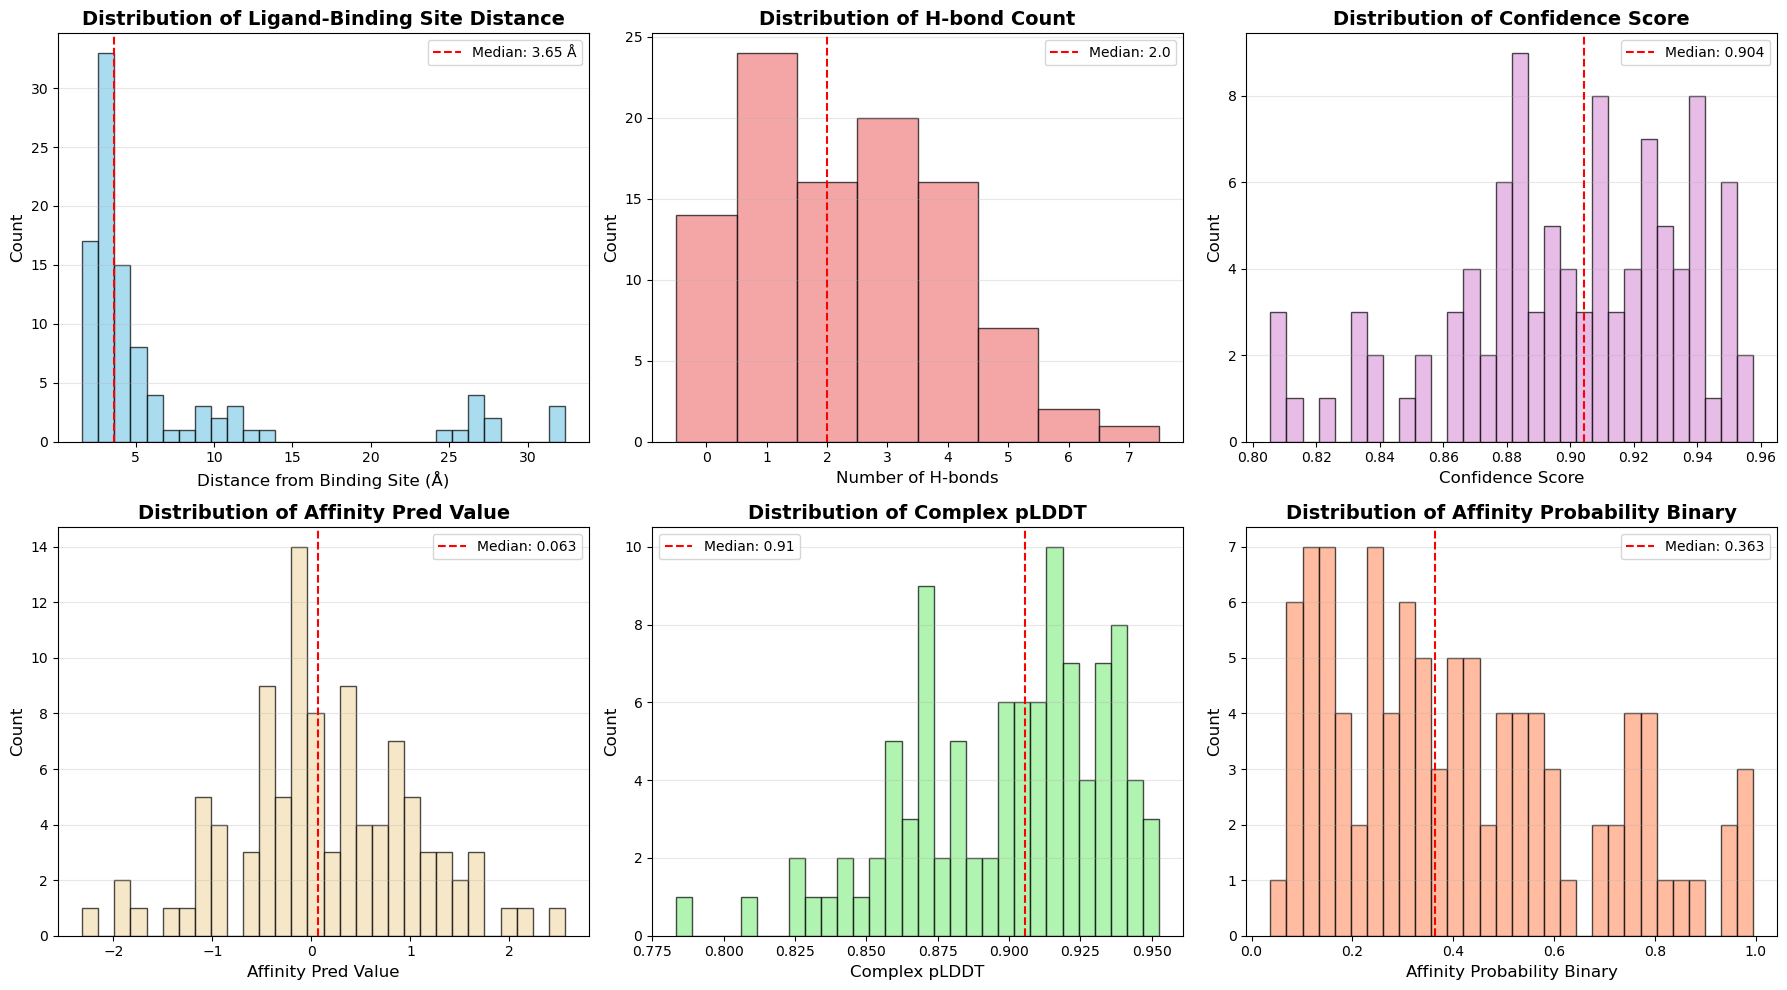


Starting with 100 valid structures (both chains found)

Applying filters:
  - Distance ≤ 10 Å: Removed 17 structures (83 remaining)
  - H-bond filter: Skipped (not configured)
  - Confidence filter: Skipped (not configured)
  - Affinity value filter: Skipped (not configured)
  - pLDDT filter: Skipped (not configured)
  - Affinity probability filter: Skipped (not configured)

Filtering Summary:
  Initial structures: 100
  Structures removed: 17
  Structures retained: 83 (83.0%)
  Filtered results saved to: filtered_results.csv

Filtered dataframe shape: (83, 42)


,cif_file,molecule_name,full_path,protein_chain,protein_chain_found,protein_sequence,protein_sequence_length,ligand_chain,ligand_chain_found,ligand_binder_name,...,pair_chains_iptm_0_1,pair_chains_iptm_1_0,pair_chains_iptm_1_1,affinity_pred_value,affinity_probability_binary,affinity_pred_value1,affinity_probability_binary1,affinity_pred_value2,affinity_probability_binary2,available_chains
2,CHEMBL260933_model_0.cif,CHEMBL260933,results/active_template/boltz_results_CHEMBL26...,[A],True,RYETVEMVFIATVTGSLSLVTVVGNILVMLSIKVNRQLQTVNNYFL...,276,[B],True,CHEMBL260933,...,0.619984,0.945627,0.871641,0.093503,0.110302,0.477922,0.099564,-0.290915,0.121039,"[A],[B]"
3,CHEMBL301265_model_0.cif,CHEMBL301265,results/active_template/boltz_results_CHEMBL30...,[A],True,RYETVEMVFIATVTGSLSLVTVVGNILVMLSIKVNRQLQTVNNYFL...,276,[B],True,CHEMBL301265,...,0.589789,0.955333,0.955294,0.320810,0.583584,0.101843,0.641031,0.539778,0.526138,"[A],[B]"
4,CHEMBL1388_model_0.cif,CHEMBL1388,results/active_template/boltz_results_CHEMBL13...,[A],True,RYETVEMVFIATVTGSLSLVTVVGNILVMLSIKVNRQLQTVNNYFL...,276,[B],True,CHEMBL1388,...,0.356733,0.894660,0.896746,1.508512,0.319546,0.947781,0.366096,2.069242,0.272996,"[A],[B]"
5,CHEMBL469912_model_0.cif,CHEMBL469912,results/active_template/boltz_results_CHEMBL46...,[A],True,RYETVEMVFIATVTGSLSLVTVVGNILVMLSIKVNRQLQTVNNYFL...,276,[B],True,CHEMBL469912,...,0.629194,0.954391,0.919652,0.965131,0.101492,0.754816,0.146021,1.175445,0.056962,"[A],[B]"
7,CHEMBL838_model_0.cif,CHEMBL838,results/active_template/boltz_results_CHEMBL83...,[A],True,RYETVEMVFIATVTGSLSLVTVVGNILVMLSIKVNRQLQTVNNYFL...,276,[B],True,CHEMBL838,...,0.694599,0.960137,0.942244,0.790781,0.144260,0.120055,0.182459,1.461507,0.106061,"[A],[B]"


,cif_file,molecule_name,full_path,protein_chain,protein_chain_found,protein_sequence,protein_sequence_length,ligand_chain,ligand_chain_found,ligand_binder_name,...,pair_chains_iptm_0_1,pair_chains_iptm_1_0,pair_chains_iptm_1_1,affinity_pred_value,affinity_probability_binary,affinity_pred_value1,affinity_probability_binary1,affinity_pred_value2,affinity_probability_binary2,available_chains
0,CHEMBL192_model_0.cif,CHEMBL192,results/active_template/boltz_results_CHEMBL19...,[A],True,RYETVEMVFIATVTGSLSLVTVVGNILVMLSIKVNRQLQTVNNYFL...,276,[B],True,CHEMBL192,...,0.691670,0.941500,0.933364,-0.110819,0.085683,-0.047975,0.151211,-0.173662,0.020156,"[A],[B]"
1,CHEMBL898_model_0.cif,CHEMBL898,results/active_template/boltz_results_CHEMBL89...,[A],True,RYETVEMVFIATVTGSLSLVTVVGNILVMLSIKVNRQLQTVNNYFL...,276,[B],True,CHEMBL898,...,0.357001,0.849715,0.910767,0.871293,0.244197,1.288043,0.232042,0.454544,0.256351,"[A],[B]"
2,CHEMBL260933_model_0.cif,CHEMBL260933,results/active_template/boltz_results_CHEMBL26...,[A],True,RYETVEMVFIATVTGSLSLVTVVGNILVMLSIKVNRQLQTVNNYFL...,276,[B],True,CHEMBL260933,...,0.619984,0.945627,0.871641,0.093503,0.110302,0.477922,0.099564,-0.290915,0.121039,"[A],[B]"
3,CHEMBL301265_model_0.cif,CHEMBL301265,results/active_template/boltz_results_CHEMBL30...,[A],True,RYETVEMVFIATVTGSLSLVTVVGNILVMLSIKVNRQLQTVNNYFL...,276,[B],True,CHEMBL301265,...,0.589789,0.955333,0.955294,0.320810,0.583584,0.101843,0.641031,0.539778,0.526138,"[A],[B]"
4,CHEMBL1388_model_0.cif,CHEMBL1388,results/active_template/boltz_results_CHEMBL13...,[A],True,RYETVEMVFIATVTGSLSLVTVVGNILVMLSIKVNRQLQTVNNYFL...,276,[B],True,CHEMBL1388,...,0.356733,0.894660,0.896746,1.508512,0.319546,0.947781,0.366096,2.069242,0.272996,"[A],[B]"


In [2]:
# Process all Boltz results
df_results = process_boltz_results_directory(
    results_dir=RESULTS_DIRECTORY,
    protein_chain_id=PROTEIN_CHAIN_ID,
    ligand_chain_id=LIGAND_CHAIN_ID,
    output_csv=OUTPUT_CSV,
    directory_prefix=DIRECTORY_PREFIX,
    calculate_binding_site_distance=CALCULATE_BINDING_SITE_DISTANCE,
    binding_site_residues=BINDING_SITE_RESIDUES,
    calculate_hbonds=CALCULATE_HBONDS,
    hbond_distance_cutoff=HBOND_DISTANCE_CUTOFF,
    hbond_angle_cutoff=HBOND_ANGLE_CUTOFF,
    calculate_vdw=CALCULATE_VDW,
    vdw_distance_cutoff=VDW_DISTANCE_CUTOFF
)

# Generate distribution plots if enabled
if DISTRIBUTION_PLOT:
    plot_distribution_metrics(df_results, output_file='distribution_plots.png')

# Apply filtering if enabled
if FILTERING:
    df_filtered = filter_results(
        df_results,
        output_csv=FILTERED_OUTPUT_CSV,
        max_ligand_distance=MAX_LIGAND_DISTANCE,
        min_hbond_count=MIN_HBOND_COUNT,
        min_confidence=MIN_CONFIDENCE,
        max_affinity_value=MAX_AFFINITY_VALUE,
        min_plddt=MIN_PLDDT,
        min_affinity_probability=MIN_AFFINITY_PROBABILITY
    )
    print(f"\nFiltered dataframe shape: {df_filtered.shape}")
    display(df_filtered.head())
else:
    print("\nFiltering is disabled. Set FILTERING = True to enable.")

# Display first few rows of original results
df_results.head()